# 딥러닝 메인 프로젝트: 작사가 인공지능 만들기
- 2025.12.11(Thu)
- 모두의 연구소 데싸6기
- Mihyn Lee

---

# ⭐️결과 요약 및 회고⭐️

## 1. 성과
- Validation Loss 최종: 2.0501 (목표 기준점 2.2 보다 효율화)
- Masked Validation Accuracy: 37.57%: 12,000개 단어 중 1개를 선택해야 하는 난이도를 고려할 때, 약 38%는 높은 성능으로 보여짐
- Epoch 8 이후부터 과적합 징후(Val Loss가 다시 올라감)가 보였으나, 재학습 혹은 하이퍼파라미터 튜닝 등을 하기에는 손실률이 크지 않아서 Epoch 10으로 진행한 모델로 작사 창작함
- my fortune, closing time, next year 등 비교적 쉬운 단어 조합에 대해서는 이해 가능한 문장을 출력함
- 단, f1 driver, python 등과 같이 다소 도메인 지식이 필요한 단어 및 단어 조합에 대해서는 출력이 없거나, 입력한 단어 그대로 출력되는 것을 확인함

## 2. 회고
- 단순 모델 학습을 넘어 학습된 모델에서 단어를 입력하여 문장을 출력하고, 이를 또 다른 모델인 Suno에서 가사 및 음악 스타일에 대한 프롬프트를 입력해서 customizing 하는 새로운 경험을 함
- 특히 시퀀스 생성 모델의 파이프라인을 실습해볼 수 있는 좋은 기회였음
- Suno AI Music "Weekday Code, Weekend Flow" https://suno.com/s/baCQPTVd88dfnOl3

---

# Step 1. 데이터 준비

In [1]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 데이터 load 및 압축 해제

import os
import zipfile

# 데이터 루트 경로 - 미리 다운받아둔 데이터로 실험 진행
data_path = '/content/drive/MyDrive/Colab Notebooks/'
lyrics_path = os.path.join(data_path, '작사가')

# 압축 파일 목록
zip_files = {
    'lyrics.zip': 'lyrics'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(data_path, zip_name)
    extract_dir = os.path.join(lyrics_path, folder_name)

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: lyrics.zip → /content/drive/MyDrive/Colab Notebooks/작사가/lyrics
✅ 모든 압축 해제 완료!


In [3]:
import glob #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import os

lyrics_file_path = '/content/drive/MyDrive/Colab Notebooks/작사가/lyrics/lyrics/*'

txt_list = glob.glob(lyrics_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

In [4]:
raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


## Step 2. 데이터 전처리

In [5]:
import re

# 모든 문장 소문자화, 구두점 양쪽 공백 삽입, 불필요한 특수문자 제거, 문장 시작 토큰/종료 토큰 추가

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = ' ' + sentence + ' ' # 6
    return sentence

corpus = list(map(preprocess_sentence, raw_corpus))

In [6]:
import numpy as np
import tensorflow as tf

# 12,000개의 단어만 사용하는 Tokenizer 함수 구축
# 정제된 문장들을 최대 길이 15의 정수 시퀀스(Tensor)로 변환 후 -> 패딩(padding='post')을 적용

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,
        filters=' ',
        oov_token=""
    )

    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[ 304   26   97 ...    0    0    0]
 [ 219   11   83 ...    0    0    0]
 [  22   15 1085 ...    0    0    0]
 ...
 [  21   75    4 ...    0    0    0]
 [  40   24    4 ...    0    0    0]
 [  21   75    4 ...    0    0    0]] <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7bafda93e120>


In [7]:
from sklearn.model_selection import train_test_split

enc_inputs = tensor[:, :-1]
dec_targets = tensor[:, 1:]


enc_train, enc_val, dec_train, dec_val = train_test_split(
    enc_inputs,       # 정수 시퀀스를 입력(enc_inputs)과
    dec_targets,      # 정답(dec_targets)으로 Shift
    test_size=0.2,    # 검증 데이터 20% 분리
    random_state=42,  # 재현성 확보 위해 시드 고정
    shuffle=True      # 데이터 섞기
)

In [8]:
enc_train

array([[2129,    2, 2129, ...,    2,  135,    2],
       [   6,  451,   77, ...,    0,    0,    0],
       [   5,   70,    4, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   1,  191,    2, ...,    0,    0,    0],
       [  38,    3,   20, ...,   12,   31,    0]], dtype=int32)

In [9]:
# 훈련 및 검증 데이터셋을 tf.data.Dataset 형태로 구성
# 배치 크기 64로 셔플(Shuffle)하여 모델 학습 준비

BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 64
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(val_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(64, 14), dtype=tf.int32, name=None), TensorSpec(shape=(64, 14), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(64, 14), dtype=tf.int32, name=None), TensorSpec(shape=(64, 14), dtype=tf.int32, name=None))>


# Step 3. 모델 구축

In [10]:
# Embedding Size 256, Hidden Size 1024를 갖는 RNN (LSTM) 기반의 시퀀스 모델 정의

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어 -> 2개의 LSTM 레이어 -> 1개의 Dense 레이어 구조
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 변환
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용됨
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!
embedding_size = 64 # 워드 벡터의 차원수 = 단어가 추상적으로 표현되는 크기 (가이드 256 -> 변경 64)
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.


# Step 4. 모델 학습

In [11]:
# 모델 학습 환경 설정
# 훈련 데이터셋(dataset)과 검증 데이터셋(val_dataset)을 사용하여 n Epoch 동안 학습을 진행
# 1회차: 5회 설정(12시 13분)

import time
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam() # 옵티마이저 Adam 사용
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다.
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

# 모델 학습 소요 시간 측정
start_time = time.time()

# 모델 학습
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=10
)

# 시간 측정 종료 및 출력
end_time = time.time()
total_time = end_time - start_time

print(f"\n✅ 총 학습 소요 시간: {total_time:.2f}초")
print(f"   (약 {total_time / 60:.2f}분)")

Epoch 1/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 363s 152ms/step - loss: 3.2776 - val_loss: 2.6156
Epoch 2/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 357s 153ms/step - loss: 2.4959 - val_loss: 2.3600
Epoch 3/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 352s 150ms/step - loss: 2.1665 - val_loss: 2.2128
Epoch 4/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 354s 151ms/step - loss: 1.8903 - val_loss: 2.1225
Epoch 5/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 354s 151ms/step - loss: 1.6663 - val_loss: 2.0653
Epoch 6/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 356s 152ms/step - loss: 1.4747 - val_loss: 2.0373
Epoch 7/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 354s 151ms/step - loss: 1.3171 - val_loss: 2.0206
Epoch 8/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 356s 152ms/step - loss: 1.1720 - val_loss: 2.0194
Epoch 9/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 354s 151ms/step - loss: 1.0551 - val_loss: 2.0341
Epoch 10/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 382s 151ms/step - loss: 0.9555 - val_loss: 2.0501

✅ 총 학습 소요 시간: 3582.78초
   (약 59.71분)


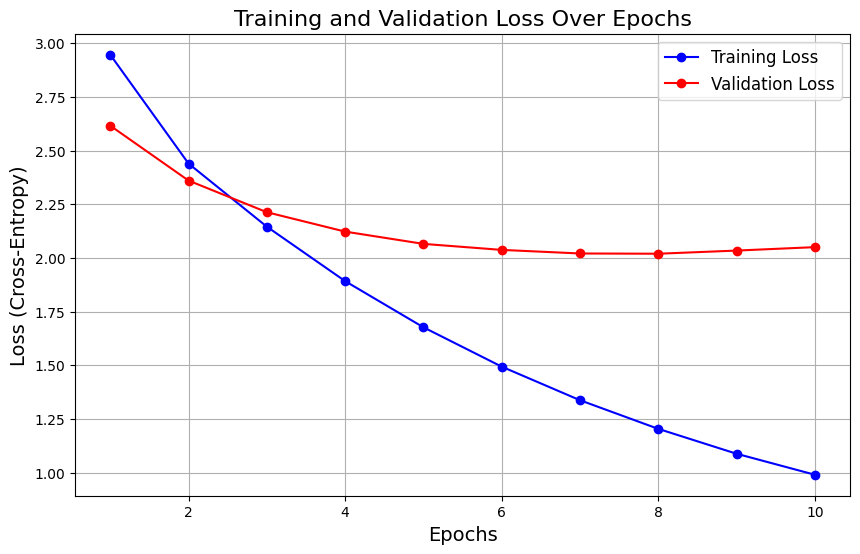

In [12]:
# 과적합 점검

import matplotlib.pyplot as plt

# 학습 기록 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss') # 훈련 손실 (파란색)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') # 검증 손실 (빨간색)

plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (Cross-Entropy)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 해석 가이드:
# 1. 두 곡선 모두 계속 하락: 정상적인 학습 진행.
# 2. 훈련 손실은 계속 하락하지만, 검증 손실이 멈추거나 상승: 과적합 시작! 학습을 중단하거나 규제(Regularization) 필요.

In [13]:
# 시퀀스 예측 정확도 계산

import numpy as np
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# 학습 데이터셋의 패딩 토큰 인덱스는 0입니다.
PAD_ID = 0

# 검증 데이터셋에서 배치 단위로 예측을 수행하여 정확도 측정
def calculate_accuracy(model, dataset, pad_id=PAD_ID):
    # Keras의 정확도 계산 Metric 객체 생성
    metric = SparseCategoricalAccuracy(name='val_accuracy')

    # 데이터셋 순회하며 배치 단위로 정확도 업데이트
    for enc, dec_true in dataset:
        # 모델 예측 (Logits)
        dec_pred_logits = model(enc)

        # 패딩을 무시하기 위한 마스크 생성 (정답이 패딩이 아닌 경우 1, 패딩인 경우 0)
        mask = tf.math.logical_not(tf.math.equal(dec_true, pad_id))

        # Metric 객체에 예측값, 정답, 마스크를 전달하여 정확도 누적
        metric.update_state(dec_true, dec_pred_logits, sample_weight=mask)

    return metric.result().numpy()

# 정확도 계산 및 출력
val_accuracy = calculate_accuracy(model, val_dataset)

print(f"\n✅ Masked Validation Accuracy (패딩 무시 정확도): {val_accuracy:.4f}")


✅ Masked Validation Accuracy (패딩 무시 정확도): 0.3757


# Step 6. 결과 확인 및 작사

In [17]:
# @title
# 텍스트 생성 함수 -> 기존 가이드 코드 오류 발생

def generate_text(model, tokenizer, init_sentence="", max_len=30): #시작 문자열을 init_sentence 로 받으며 디폴트값은  를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index[""]

    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor)
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [19]:
# 텍스트 생성 함수

def generate_text(model, tokenizer, init_sentence="", max_len=30):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)

    # ⚠️ 토크나이저를 만들 때 OOV 토큰을 ""으로 설정했기 때문에, end_token을 0으로 설정해야 할 수도 있습니다.
    # 안전하게 처리하기 위해 <end> 토큰의 인덱스를 찾아 사용합니다.
    # 만약 <end> 토큰이 없다면 빈 문자열 ""로 대체합니다.
    try:
        end_token = tokenizer.word_index["<end>"]
    except KeyError:
        # 만약 <end> 토큰이 없다면, 토크나이저 설정에 따라 OOV 토큰("")을 사용하거나,
        # 문장 최대 길이에 도달했을 때만 멈추도록 설정할 수 있습니다.
        end_token = tokenizer.word_index.get("", None)

    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성
        # 1
        predict = model(test_tensor)
        # 2
        # tf.argmax를 사용하여 예측된 단어 인덱스를 추출
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다
    for word_index in test_tensor[0].numpy():
        # 💡 수정된 부분: word_index가 0 (패딩 토큰)인 경우 건너뜁니다.
        if word_index == 0:
            continue

        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [35]:
# 모델을 활용해 가사 생성
# init_sentence 양 끝에 공백을 넣고 소문자로 유지하는 것이 중요

generate_text(model, tokenizer, init_sentence=" my fortune ", max_len=30)

'my fortune send me in the water , '

In [36]:
generate_text(model, tokenizer, init_sentence=" fortune ", max_len=30)

'fortune telling by daisy petals '

In [37]:
generate_text(model, tokenizer, init_sentence=" next year ", max_len=30)

'next year i got some drugs with you i m on one , '

In [45]:
generate_text(model, tokenizer, init_sentence=" faith ", max_len=30)

'faith is an island in the setting sun '

In [49]:
generate_text(model, tokenizer, init_sentence=" patience ", max_len=30)

'patience is in your eyes '

In [52]:
generate_text(model, tokenizer, init_sentence=" closin ", max_len=30)

'closin again , i m gonna wear this club s right i m running through the dark '

In [58]:
generate_text(model, tokenizer, init_sentence=" tag code ", max_len=30)

'tag code like a deuce '